In [46]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pip install pyloess

In [2]:
from pathlib import Path

In [5]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
from typing import Tuple

import numpy as np
import pandas as pd

from dataset import Dataset
import matplotlib.pyplot as plt
from plotting import plot_ts
from pyloess import loess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller

Задание 1

Рассмотрите ряд data/dataset/stl_example.csv.
   Постройте для него график автокорреляции. Обьясните закономерности, которые вы видите.

In [5]:
dataset = Dataset('./data/dataset/')

In [6]:
ts_ = dataset['stl_example.csv']

In [52]:
plot_ts(ts_)

Loading BokehJS ...

По графикам наблюдается возрастающий тренд и сезонность с периодичностью 6 часов, ряд гомоскедастичен.

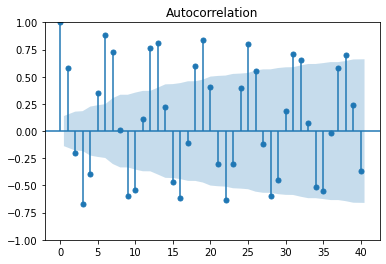

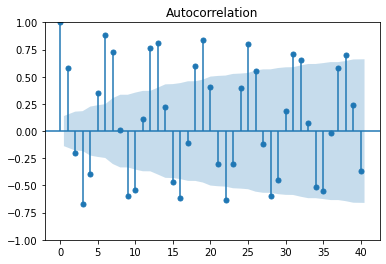

In [55]:
plot_acf(ts_, lags = 40)

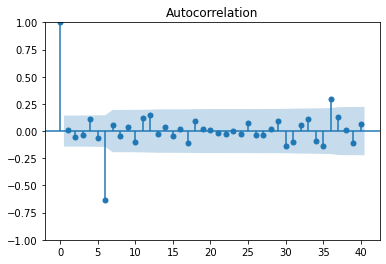

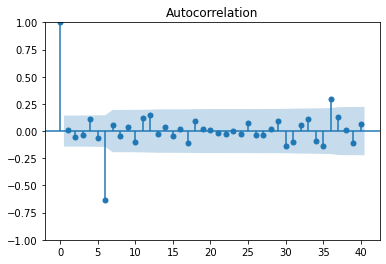

In [31]:
plot_acf(ts_.diff(6).diff(6).dropna(), lags = 40)

Используя определение стационарности ряда, докажите, что следующий процесс
стационарен.  
y_t = 5 + e_t + 3e_{t-1} - 2e_{t-2}, e_t \~ N(0, \sigma^2)

Е(y_t) = E(5 + e_t + 3e_{t-1} - 2e_{t-2}) = 5 +E(e_t) + 3E(e_{t-1}) - 2E(e_{t-2}) = 5; E(e_t) = 0

VAR(y_t) = VAR(5 + e_t + 3e_{t-1} - 2e_{t-2}) = VAR(e_t) + 9*VAR(e_{t-1}) + 4*VAR(e_{t-2}) = 14 sigma^2; VAR(e_t) = sigma^2


Ковариация

Y(0) = COV(y_t;y_t) = VAR(y_t) = 14 sigma^2


Y(1) = COV(y_t;y_{t-1}) = COV(5 + e_t + 3e_{t-1} - 2e_{t-2}; 5 + e_{t-1} + 3e_{t-2}- 2e_{t-3}) = COV(3e_{t-1};e_{t-1}) + COV(- 2e_{t-2};3e_{t-2}) =

3*COV(e_{t-1};e_{t-1}) - 6* COV(e_{t-2};e_{t-2} = 3*VAR(e_{t-1}) - 6*VAR(e_{t-1}) = -3 sigma^2


Y(2) = COV(y_t;y_{t-1}) = COV(5 + e_t + 3e_{t-1} - 2e_{t-2}; 5 + e_{t-2} + 3e_{t-3}- 2e_{t-4}) = COV(- 2e_{t-2};e_{t-2}) = -2* COV(e_{t-2};e_{t-2}) = -2sigma^2

                              
Y(3) = COV(y_t;y_{t-1}) = COV(5 + e_t + 3e_{t-1} - 2e_{t-2};  5 + e_{t-3} + 3e_{t-4} - 2e_{t-5}) = 0   
                                
Y(n> 3) = 0                               

#### Возьмем типичный пример ряда с трендом и сезонностью

In [10]:
dataset = Dataset('../data/dataset/')

In [34]:
ts = dataset['international-airline-passengers-anomaly.csv']

<AxesSubplot:xlabel='1949-01'>

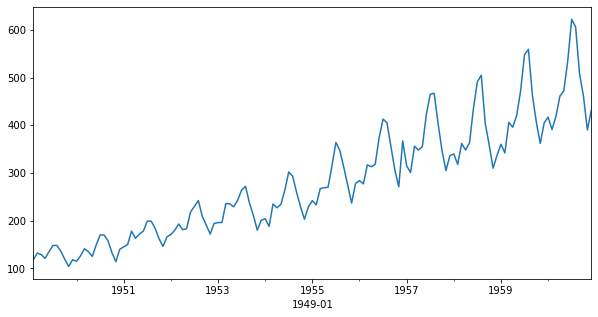

In [35]:
ts.plot(figsize=(10, 5))

### Задание 1 - реализовать "наивную" имплементацию stl-разложения:
    Ряд - stl_example.csv

    0. Убрать гетероскедастичность логарифмированием.
    1. Апроксимировать ряд линейным трендом.
    2. Вычесть линейный тренд из ряда.
    3. Найти период сезонности получившегося ряда по коррелограме.
    4. Получить сезонность ряда без тренда одним из двух способов: 
       а) при помощи медианного фильтра с окном равным период/к, к подобрать, обычно хорошо подходит k={2, 3, 4}. 
       (Чтобы фильтр считался по центру скользящего окна, используйте опцию ts.rolling(k, center=True).median())
       б) продифференцировав его с лагом, равным найденному периоду сезонности и вычтя
       получившийся ряд из исходного
       в)* попробуйте подумать, какие есть плюсы и минусы у каждого из способов?
    5. Вычесть тренд и сезонность, получить остатки.
    6. Проверить остатки на стационарность.

   
detect_ts должна возвращать tuple из: (тренд, сезонность, остатки)

In [36]:
def extract_trend(ts: pd.Series,  predict = 0):
    """
    Извлекает линейный тренд из временного ряда
    """
    if predict == 0:
        trend = loess(np.arange(0, len(ts.index)),ts.values,np.arange(0, len(ts.index)), degree = 1, span = .3)
    else:
        trend = loess(np.arange(0, len(ts.index)),ts.values,np.arange(0,len(ts.index)+ predict+1)[1:], degree = 1, span = .3)[-predict:]
    return trend

In [37]:
def extract_seasonality(ts_detrended, period=None):
    """
    Извлекает сезонную компоненту
    """
    season = ts_detrended.rolling(period, center = True).median()
    return season

In [38]:
def extract_seasonality_diff(ts_detrended, period=None):
    """
    Извлекает сезонную компоненту при помощи дифференцирования
    """
    Rt = ts_detrended.diff(period)
    season = ts_detrended - Rt
    
    return season

In [39]:
# Можно разложить по данной функции, ниже ее не использовал.

def detect_ts(ts, season_method = 'diff' ,period = None):
    
    trend = extract_trend(ts)
    ts_detrended = ts - trend
    
    if season_method == 'diff':
        season = extract_seasonality_diff(ts_detrended, period=period).dropna()
    else:
        season = extract_seasonality(ts_detrended, period=period).dropna()
        
    resid = ts_detrended - season
    
    return (pd.Series(trend,ts.index),season,resid)



<AxesSubplot:xlabel='1949-01'>

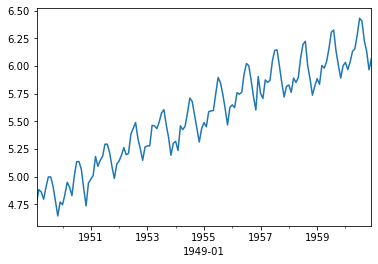

In [40]:
ts = np.log(ts)
ts.plot()

<AxesSubplot:title={'center':'Trend'}, xlabel='1949-01'>

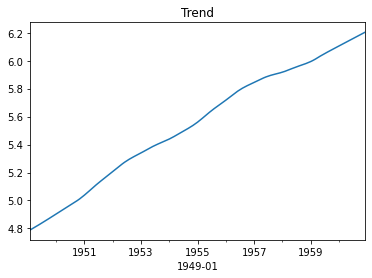

In [41]:
#1. Апроксимировать ряд линейным трендом.
trend = extract_trend(ts)

Y_detr = ts - trend
pd.Series(data = trend, index= ts.index).plot(title = 'Trend')

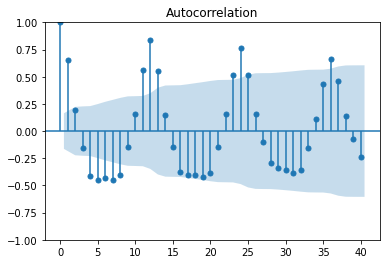

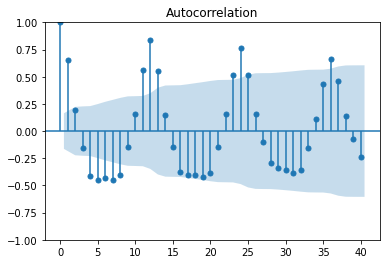

In [42]:
#3. Найти период сезонности получившегося ряда по коррелограме. Период 12.
plot_acf(Y_detr, lags = 40)

2.269434490868676e-07

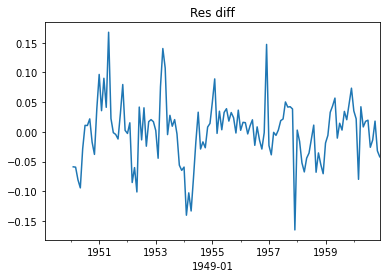

In [44]:
#4. Получить сезонность:
season_diff = extract_seasonality_diff(Y_detr, period=12)

res_diff = Y_detr - season_diff

res_diff.plot(title = 'Res diff')
adfuller(res_diff.dropna())[1]

0.0020180845347803106


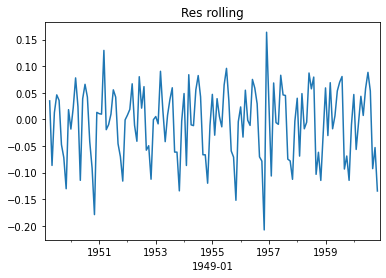

In [46]:
#4. Получить сезонность:(а)
season_roll = extract_seasonality(Y_detr,4)


res_roll = Y_detr - season_roll

res_roll.plot(title = 'Res rolling')
print(adfuller(res_roll.dropna())[1])

Способ находждения сезонности путем диффиренцирования: теряем первые точки ряда

Способ медианного фильтра: теряются первые и последние значение ряда.

Ряд становится стационарным при применении обоих методов.

### Задание 2 - найти аномалии во временном ряде при помощи получившихся остатков 

1. Расчитать стандартное отклонение остатков std
2. Получить порог на остатки по формуле `threshold = k * std`, k обычно берется от 2 до 3.
3. Найти аномалии, как точки ряда, абсолютные значения которых превышают найденный порог

In [47]:
threshold = 2.7
std = res_diff.std()
mean = res_diff.mean()


upper = mean + threshold*std
lower = mean - threshold*std

print(res_diff[(res_diff >upper ) |(res_diff < lower )])

plot_ts(res_diff, pd.Series(upper,ts.index), pd.Series(lower, ts.index))

1949-01
1951-05-01    0.167637
1954-02-01   -0.140420
1956-12-01    0.147140
1957-12-01   -0.165166
Name: 112, dtype: float64


Loading BokehJS ...

### Задание 3 - сделать прогноз ряда на 6 периодов вперед (36 точек)

1. Экстраполируйте линейный тренд.
2. Сделайте рекурсивный прогноз сезонной компоненты по формуле y(t) = y(t-6)
3. Остатки по-хорошему должны моделироваться моделью arma, но в нашем случае сделайте просто прогноз средним значением. (Т.к. в нашем случае это 0, остатки можно вообще проигнорировать)
4. Сложите получившиеся компоненты и получите финальный прогноз
5. profit!

In [48]:
trend_pred = extract_trend(ts, predict=36)

plot_ts(pd.Series(data = trend_pred,
          index=pd.date_range(start=ts.index[-1], periods=37, freq ='M')[1:]),pd.Series(trend, ts.index))

Loading BokehJS ...

In [49]:
season_pred = np.array(list(season_diff[-12:])*3)

In [50]:
Y_pred = np.exp(trend_pred + season_pred)

In [51]:
plot_ts(np.exp(ts), pd.Series(Y_pred, index=pd.date_range(start=ts.index[-1], periods=37, freq ='M')[1:]))

Loading BokehJS ...

### stl-Разложение "из коробки" - statsmodels. 

In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [151]:
decomp = seasonal_decompose(ts, period=12)

<AxesSubplot:xlabel='1949-01'>

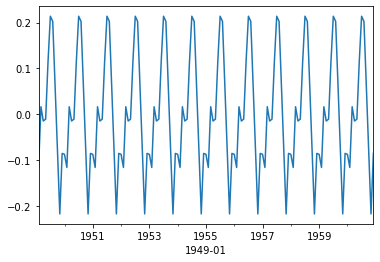

In [152]:
decomp.seasonal.plot()

<AxesSubplot:xlabel='1949-01'>

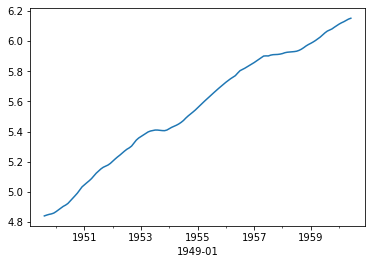

In [153]:
decomp.trend.plot()

<AxesSubplot:xlabel='1949-01'>

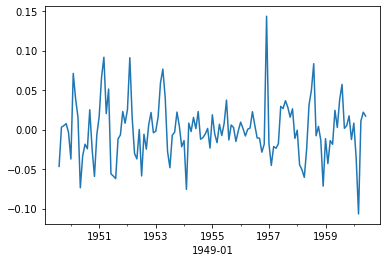

In [154]:
decomp.resid.plot()

In [155]:
adfuller(decomp.resid.dropna())

(-6.664410821352989,
 4.7574971556835916e-09,
 9,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 -472.814120480361)

### Другие пакеты
- stldecompose (также "наивная реализация")
- pyloess (давно не было обновлений)